In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import neurokit2 as nk
import sys
import os

In [ ]:
import argparse
import sys
from main import parse_args as parse_args_main

def main(args):
    # 在这里使用 args 进行训练或其他操作
    args=parse_args_main()
    print(f"Task: {args.task}")
    print(f"Dataset Name: {args.dataset_name}")
    print(f"Train Data Path: {args.train_data_path}")
    print(f"Model Name: {args.model_name}")
    print(f"Mask Type: {args.mask_type}")
    return args
    # 其他代码...

if __name__ == "__main__":
    # 模拟命令行参数
    sys.argv = [
        'main.py',  # 通常是脚本名
        '--task', 'finetune',
        '--dataset_name', 'ptb-xl',
        '--train_data_path', '/root/data/ptb-xl/train.txt',
        '--val_data_path', '/root/data/ptb-xl/val.txt',
        '--model_name', 'FocusMae',
        '--mask_type', 'period',
        # 添加其他必要的参数
    ]

    parser = argparse.ArgumentParser(description='Pretrain or finetune model')
    # 添加参数
    parser.add_argument('--task', type=str, required=True, help='Task to perform')
    parser.add_argument('--dataset_name', type=str, required=True, help='Name of the dataset')
    parser.add_argument('--train_data_path', type=str, required=True, help='Path to the training data')
    parser.add_argument('--val_data_path', type=str, required=True, help='Path to the validation data')
    parser.add_argument('--model_name', type=str, required=True, default='FocusMae',help='Name of the model to use')
    parser.add_argument('--mask_type', type=str, default='period', help='Type of mask to use')  
    parser.add_argument('--ckpt_path', type=str, default='/root/ecg_ai/FocusECG/FocusECG/min_val_loss=34.49940490722656.pth', help='Type of mask to use')  
    parsed_args=parse_args_main()
    # 解析参数
    args = parser.parse_args()

    for key, value in vars(parsed_args).items():
        if value is not None:
            setattr(args, key, value)

    # 调用主函数
    main(args)

In [86]:
import torch
import torch.nn as nn
import numpy as np
import math

import torch.fft as fft
from einops import rearrange, reduce, repeat
class FourierLayer(nn.Module):

    def __init__(self, pred_len, k=None, low_freq=1, output_attention=False):
        super().__init__()
        # self.d_model = d_model
        self.pred_len = pred_len
        self.k = k
        self.low_freq = low_freq
        self.output_attention = output_attention

    def forward(self, x):
        """x: (b, t, d)"""

        if self.output_attention:
            return self.dft_forward(x)

        b, t, d = x.shape
        x_freq = fft.rfft(x, dim=1)

        if t % 2 == 0:
            x_freq = x_freq[:, self.low_freq:-1]
            f = fft.rfftfreq(t)[self.low_freq:-1]
        else:
            x_freq = x_freq[:, self.low_freq:]
            f = fft.rfftfreq(t)[self.low_freq:]

        x_freq, index_tuple = self.topk_freq(x_freq)
        f = repeat(f, 'f -> b f d', b=x_freq.size(0), d=x_freq.size(2))
        f = f.to(x_freq.device)
        f = rearrange(f[index_tuple], 'b f d -> b f () d').to(x_freq.device)
        print(f.shape)
        print("f:",1/f[0])
        return self.extrapolate(x_freq, f, t), None

    def extrapolate(self, x_freq, f, t):
        x_freq = torch.cat([x_freq, x_freq.conj()], dim=1)
        f = torch.cat([f, -f], dim=1)
        t_val = rearrange(torch.arange(t + self.pred_len, dtype=torch.float),
                          't -> () () t ()').to(x_freq.device)

        amp = rearrange(x_freq.abs() / t, 'b f d -> b f () d')
        print("amp.shape:",amp.shape)
        print("1/amp[0]:",1/amp[0])
        phase = rearrange(x_freq.angle(), 'b f d -> b f () d')

        x_time = amp * torch.cos(2 * math.pi * f * t_val + phase)
        print("x_time.shape:",x_time.shape)
        print("x_time[0]:",x_time[0]*250)
        return reduce(x_time, 'b f t d -> b t d', 'sum')

    def topk_freq(self, x_freq):
        values, indices = torch.topk(x_freq.abs(), self.k, dim=1, largest=True, sorted=True)
        mesh_a, mesh_b = torch.meshgrid(torch.arange(x_freq.size(0)), torch.arange(x_freq.size(2)))
        index_tuple = (mesh_a.unsqueeze(1), indices, mesh_b.unsqueeze(1))
        x_freq = x_freq[index_tuple]
        print(x_freq.shape)
        print(1/x_freq[0])
        return x_freq, index_tuple

    def dft_forward(self, x):
        T = x.size(1)

        dft_mat = fft.fft(torch.eye(T))
        i, j = torch.meshgrid(torch.arange(self.pred_len + T), torch.arange(T))
        omega = np.exp(2 * math.pi * 1j / T)
        idft_mat = (np.power(omega, i * j) / T).cfloat()

        x_freq = torch.einsum('ft,btd->bfd', [dft_mat, x.cfloat()])

        if T % 2 == 0:
            x_freq = x_freq[:, self.low_freq:T // 2]
        else:
            x_freq = x_freq[:, self.low_freq:T // 2 + 1]

        _, indices = torch.topk(x_freq.abs(), self.k, dim=1, largest=True, sorted=True)
        indices = indices + self.low_freq
        indices = torch.cat([indices, -indices], dim=1)

        dft_mat = repeat(dft_mat, 'f t -> b f t d', b=x.shape[0], d=x.shape[-1])
        idft_mat = repeat(idft_mat, 't f -> b t f d', b=x.shape[0], d=x.shape[-1])

        mesh_a, mesh_b = torch.meshgrid(torch.arange(x.size(0)), torch.arange(x.size(2)))

        dft_mask = torch.zeros_like(dft_mat)
        dft_mask[mesh_a, indices, :, mesh_b] = 1
        dft_mat = dft_mat * dft_mask

        idft_mask = torch.zeros_like(idft_mat)
        idft_mask[mesh_a, :, indices, mesh_b] = 1
        idft_mat = idft_mat * idft_mask

        attn = torch.einsum('bofd,bftd->botd', [idft_mat, dft_mat]).real
        return torch.einsum('botd,btd->bod', [attn, x]), rearrange(attn, 'b o t d -> b d o t')

In [87]:
f=FourierLayer(2250,3)
result=f.forward(batch.transpose(1, 2))
result

torch.Size([512, 3, 1])
tensor([[-0.0026-0.0004j],
        [-0.0027-0.0013j],
        [ 0.0034+0.0012j]], device='cuda:0')
torch.Size([512, 3, 1, 1])
f: tensor([[[31.6901]],

        [[52.3256]],

        [[19.7368]]], device='cuda:0')
amp.shape: torch.Size([512, 6, 1, 1])
1/amp[0]: tensor([[[6.0386]],

        [[6.8525]],

        [[7.9929]],

        [[6.0386]],

        [[6.8525]],

        [[7.9929]]], device='cuda:0')
x_time.shape: torch.Size([512, 6, 4500, 1])
x_time[0]: tensor([[[-40.8778],
         [-41.3687],
         [-40.2387],
         ...,
         [-30.1846],
         [-35.1740],
         [-38.7864]],

        [[-32.7756],
         [-34.4591],
         [-35.6463],
         ...,
         [-25.0245],
         [-28.0253],
         [-30.6211]],

        [[ 29.5271],
         [ 31.2728],
         [ 29.8759],
         ...,
         [  8.6346],
         [ 17.6105],
         [ 24.8165]],

        [[-40.8778],
         [-41.3687],
         [-40.2387],
         ...,
         [-30.1

(tensor([[[-0.3530],
          [-0.3564],
          [-0.3681],
          ...,
          [-0.3726],
          [-0.3647],
          [-0.3567]],
 
         [[-0.0314],
          [-0.0108],
          [-0.0042],
          ...,
          [-0.1800],
          [-0.1165],
          [-0.0667]],
 
         [[-0.2109],
          [-0.1921],
          [-0.1726],
          ...,
          [-0.2623],
          [-0.2461],
          [-0.2289]],
 
         ...,
 
         [[ 0.0956],
          [ 0.1287],
          [ 0.1653],
          ...,
          [ 0.0412],
          [ 0.0497],
          [ 0.0685]],
 
         [[-0.3970],
          [-0.3870],
          [-0.3733],
          ...,
          [-0.4042],
          [-0.4056],
          [-0.4032]],
 
         [[-0.5733],
          [-0.6766],
          [-0.7600],
          ...,
          [-0.1839],
          [-0.3223],
          [-0.4538]]], device='cuda:0'),
 None)

In [103]:
def fft_count(x):
    B,N,L=x.shape
    x_np = x.detach().cpu().numpy()
    X_fft = np.fft.rfft(x_np, axis=2)
    phases = np.angle(X_fft)
    freqs = np.fft.fftfreq(L, d=1/250)[2:-1]
    X_fft_energy = np.abs(X_fft) ** 2
    sorted_indices = np.argsort(X_fft_energy, axis=2)[:, :, -10:]
    main_freqs = freqs[np.argsort(X_fft_energy, axis=2)[:, :, -10:]]  # Top-6频率
    main_freqs=main_freqs[:,:,0::2]
    main_periods = np.abs(1 / main_freqs)*250
    return main_periods

In [104]:
from dataset import PretrainDataset
from torch.utils.data import DataLoader
from config import FocusMaePreTrainConfig as PreTrainConfig
from finetune_test import get_model
import signal
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import neurokit2 as nk
import sys
import os
from tqdm import tqdm
def dataloader_signal_handle(worker_id):
    def signal_handler(sig, frame):
        pass
    signal.signal(signal.SIGTERM, signal_handler)
total_sum = 0
total_count = 0
train_data_path="/root/data/FocusMAE/train.txt"
train_dataset = PretrainDataset(train_data_path)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, worker_init_fn=dataloader_signal_handle,pin_memory=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(41)
torch.cuda.manual_seed(41)
print(device)
for batch in tqdm(train_dataloader, desc="Processing Batches"):

    batch = batch.to(device)
    main_period=fft_count(batch)
    print(main_period.shape)
    print(main_period)
    break

cuda


Processing Batches:   0%|          | 0/247 [00:00<?, ?it/s]

(512, 1, 5)
[[[ 25.56818182  13.00578035  17.30769231  22.05882353  50.        ]]

 [[ 41.66666667  33.58208955  34.09090909  80.35714286 150.        ]]

 [[ 40.17857143 250.          80.35714286  34.09090909  83.33333333]]

 ...

 [[ 40.90909091  66.17647059  40.17857143  97.82608696  50.        ]]

 [[ 51.13636364  33.08823529  50.          80.35714286  62.5       ]]

 [[ 54.87804878  32.14285714  77.5862069   23.19587629  27.10843373]]]


Processing Batches:   0%|          | 0/247 [00:01<?, ?it/s]


In [94]:
main_period[5]

array([[ 56.25      , 204.54545455,  54.87804878]])

In [100]:
# 查找是否有超过 200 的值
result = np.where(main_period > 200)

# 输出结果
if result[0].size > 0:
    print(f"超过 200 的值索引为: {result}")
    print(f"值为: {batch[result]}")
else:
    print("没有超过 200 的值")

超过 200 的值索引为: (array([  2,   5,   9,  14,  21,  22,  22,  32,  36,  36,  40,  41,  46,
        47,  49,  55,  71,  73,  75,  75,  75,  78,  80,  80,  85,  85,
        88,  88,  94,  99, 104, 104, 105, 105, 107, 124, 125, 125, 125,
       130, 131, 131, 132, 139, 145, 145, 145, 152, 153, 164, 172, 175,
       175, 175, 179, 181, 187, 188, 192, 192, 192, 193, 194, 195, 198,
       199, 204, 208, 210, 216, 220, 238, 240, 243, 243, 248, 252, 253,
       253, 257, 259, 261, 268, 269, 272, 281, 284, 298, 301, 301, 302,
       303, 313, 318, 319, 322, 338, 340, 345, 354, 361, 365, 371, 371,
       377, 384, 387, 395, 396, 397, 401, 420, 421, 424, 429, 431, 431,
       435, 439, 449, 449, 450, 455, 455, 456, 457, 461, 463, 464, 468,
       477, 478, 478, 480, 494, 494, 496, 497, 497, 499, 502, 503]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

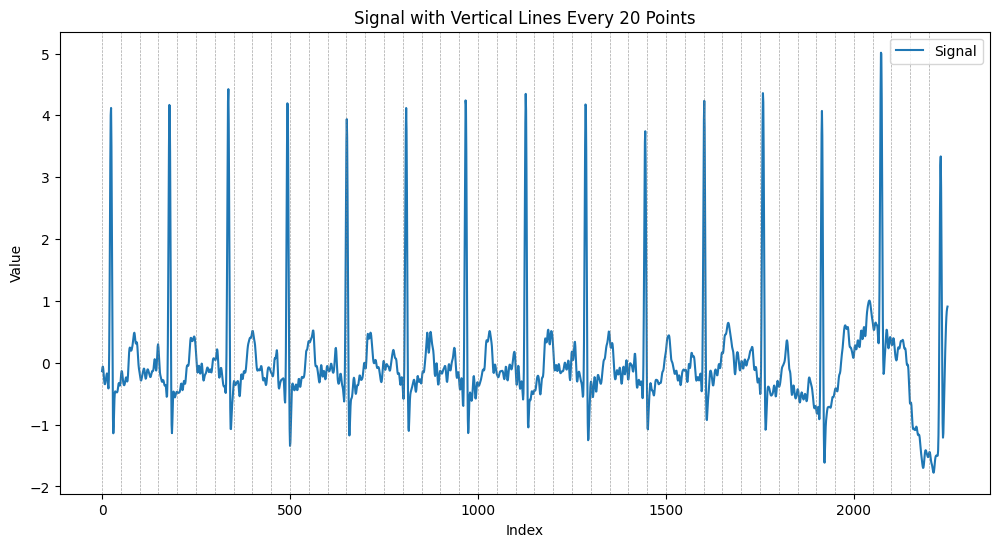

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# 示例数据
data = batch[0,0,:].cpu().detach().numpy()  # 生成一个长度为 2500 的随机数据

# 创建画布
plt.figure(figsize=(12, 6))

# 绘制数据曲线
plt.plot(data, label='Signal')

# 添加竖线
for x in range(0, len(data), 50):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# 添加标题和图例
plt.title('Signal with Vertical Lines Every 20 Points')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')

# 显示图像
plt.show()


In [16]:
signal = batch[i].cpu().numpy()
signal.shape

(1, 2250)

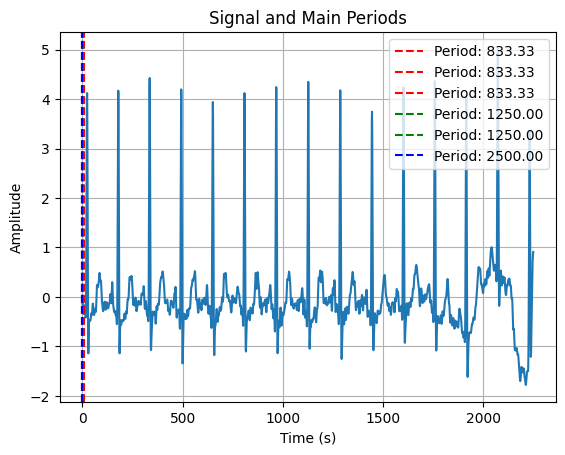

In [60]:
import numpy as np
import matplotlib.pyplot as plt

sampling_rate=250
plt.plot(batch[0, 0, :].cpu().detach().numpy())
colors = ['r', 'g', 'b', 'orange', 'purple']

for i, period in enumerate(main_periods[0]):
    if period > 0:  # 跳过无效周期
        for start in np.arange(0, len(batch[0,0,:]), period):
            plt.axvline(x=start / sampling_rate, color=colors[i % len(colors)], linestyle="--", label=f"Period: {period:.2f}")

plt.title("Signal and Main Periods")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="upper right")
plt.grid()
plt.show()


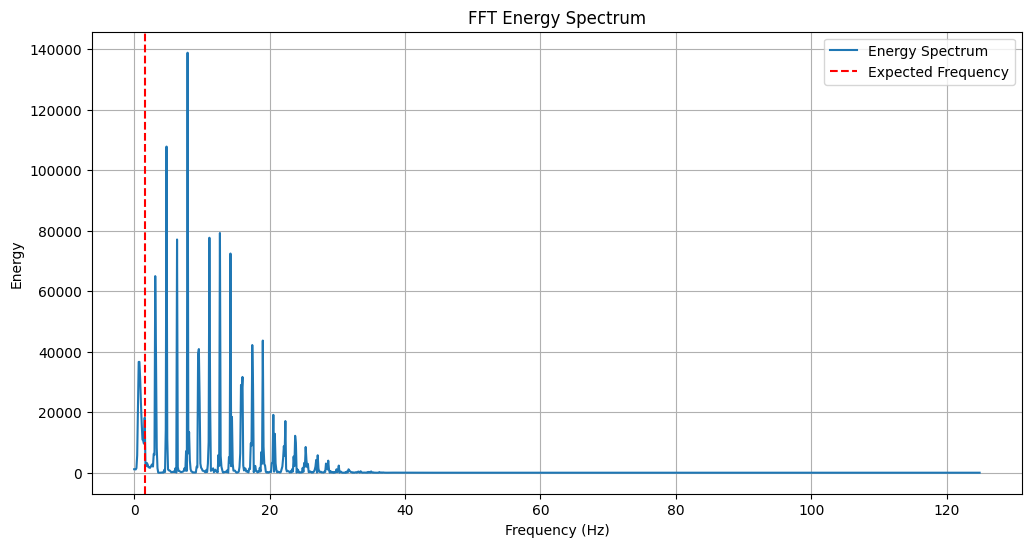

In [35]:
def plot_fft_energy(signal, sampling_rate):
    B, N, L = signal.shape
    x_np = signal.reshape(-1, L)
    X_fft = np.fft.fft(x_np, axis=1)
    freqs = np.fft.fftfreq(L, d=1 / sampling_rate)
    X_fft_energy = np.abs(X_fft) ** 2

    # 绘制能量谱
    plt.figure(figsize=(12, 6))
    plt.plot(freqs[:L // 2], X_fft_energy[0, :L // 2], label="Energy Spectrum")
    plt.axvline(x=sampling_rate / 150, color='red', linestyle="--", label="Expected Frequency")
    plt.title("FFT Energy Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid()
    plt.show()

plot_fft_energy(batch.cpu().detach().numpy(), sampling_rate=250)


In [46]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_energy(signal, sampling_rate):
    """
    计算信号的频率能量谱
    Args:
        signal: 输入信号 (形状: [B, L], B 是批量大小, L 是信号长度)
        sampling_rate: 采样率
    
    Returns:
        freqs: 频率数组
        energy: 能量谱数组
    """
    # 对信号进行 FFT
    fft_result = np.fft.fft(signal, axis=1)  # 按列 (时间维度) 进行 FFT
    freqs = np.fft.fftfreq(signal.shape[1], d=1/sampling_rate)  # 频率数组

    # 计算能量谱
    energy = np.abs(fft_result) ** 2  # 能量 = 幅值平方

    # 截取正频部分
    positive_freqs = freqs[:signal.shape[1] // 2]  # 只保留正频率
    positive_energy = energy[:, :signal.shape[1] // 2]  # 保留正频对应的能量

    return positive_freqs, positive_energy


def get_top_k_periods(freqs, energy, k=3):
    """
    获取能量最高的前 k 个频率及对应周期
    Args:
        freqs: 频率数组
        energy: 能量数组
        k: 选择前 k 个频率
    
    Returns:
        top_periods: 前 k 个周期
        top_freqs: 前 k 个频率
        top_energies: 对应能量值
    """
    # 按能量排序，获取前 k 个索引
    top_indices = np.argsort(energy)[-k:][::-1]  # 从大到小排序
    top_freqs = freqs[top_indices[0]]  # 获取对应的频率
    top_energies = energy[top_indices]  # 获取对应的能量值

    # 计算周期 (周期 = 1 / 频率，注意要避免频率为 0)
    top_periods = 1 / top_freqs

    return top_periods, top_freqs, top_energies

# 示例信号
sampling_rate = 250  # 采样率 250Hz
t = np.linspace(0, 10, sampling_rate * 10)  # 10秒的时间序列
signal = np.sin(2 * np.pi * 1 * t) + 0.5 * np.sin(2 * np.pi * 2 * t)  # 1Hz 和 2Hz 的混合信号
signal = signal.reshape(1, -1)  # 模拟批量信号

# 计算能量谱
freqs, energy = calculate_energy(batch[0].cpu().detach().numpy(), sampling_rate)
# 获取前三个周期
top_periods, top_freqs, top_energies = get_top_k_periods(freqs, energy, k=3)

# 打印结果
print("Top 3 Frequencies and Periods:")
for i in range(3):
    print(f"Frequency: {top_freqs[i]:.3f} Hz, Period: {top_periods[i]:.3f} s, Energy: {top_energies[i]:.3f}")

# # 绘制能量谱
# plt.figure(figsize=(12, 6))
# plt.plot(batch[0,0,:].cpu().detach().numpy(), energy[0], label="Energy Spectrum")
# plt.title("Energy Spectrum")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Energy")
# plt.legend()
# plt.grid()
# plt.show()
# print(signal.shape)


IndexError: index 371 is out of bounds for axis 0 with size 1

In [42]:
freqs

array([0.00000000e+00, 1.11111111e-01, 2.22222222e-01, ...,
       1.24666667e+02, 1.24777778e+02, 1.24888889e+02])

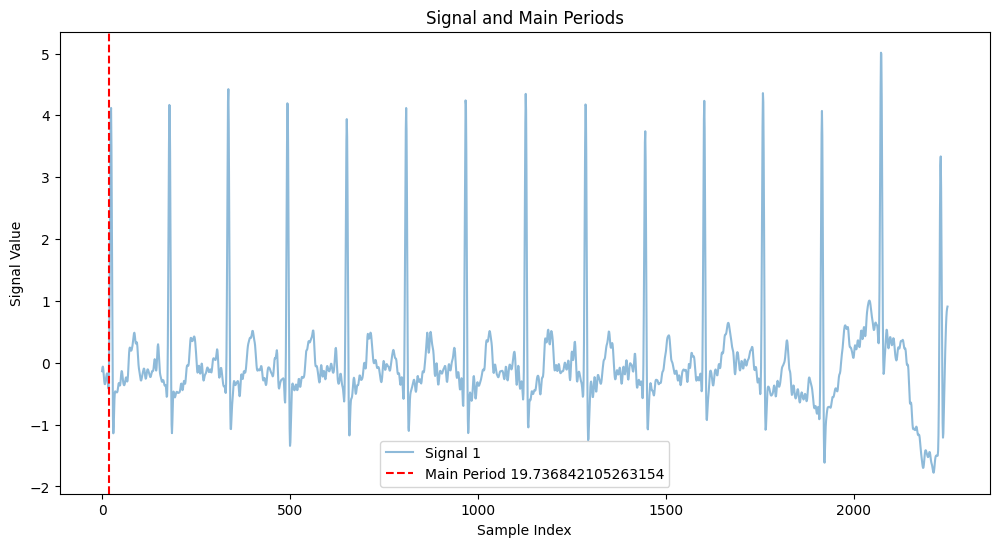

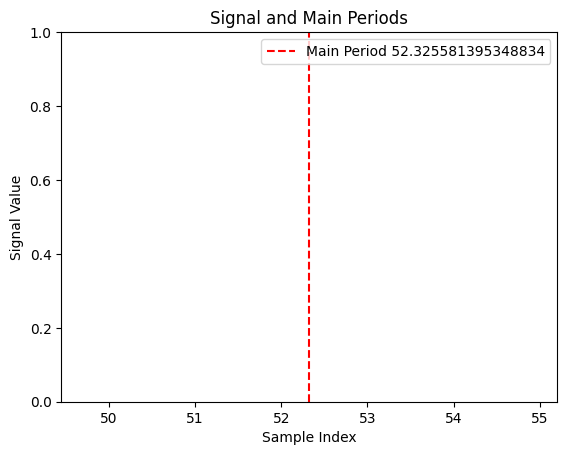

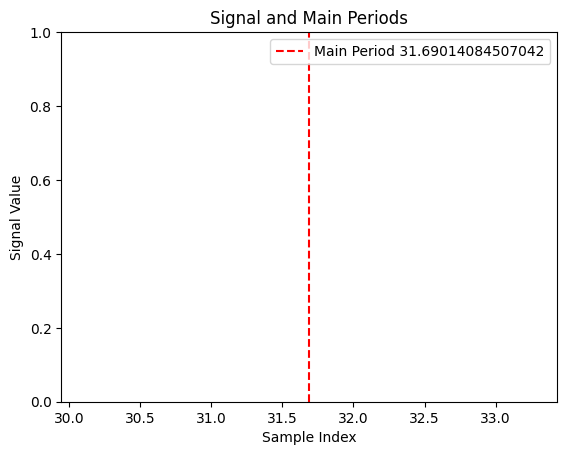

In [17]:
# 可视化信号和 main_period

plt.figure(figsize=(12, 6))
i=0
signal = batch[i,0].cpu().numpy()
plt.plot(signal, label=f'Signal {i+1}', alpha=0.5)
# 绘制 main_period 的位置
for period in main_period[i, 0]:
    plt.axvline(x=period, color='r', linestyle='--', label=f'Main Period {period}')
    plt.title('Signal and Main Periods')
    plt.xlabel('Sample Index')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.show()

In [49]:
# 定义范围边界
bins = np.arange(0, 1000, 50)  # 0-75, 75-150, 150-225, 225-300

# 使用 digitize 将数据分组到范围中
digitized = np.digitize(main_period, bins)

# 统计每个范围内的元素数量
counts = np.zeros(len(bins) - 1, dtype=int)
for i in range(1, len(bins)):
    counts[i-1] = np.sum(digitized == i)

# 打印结果
for i in range(len(counts)):
    print(f"范围 {bins[i]}-{bins[i+1]}: {counts[i]} 个元素")

范围 0-50: 603 个元素
范围 50-100: 538 个元素
范围 100-150: 131 个元素
范围 150-200: 67 个元素
范围 200-250: 83 个元素
范围 250-300: 77 个元素
范围 300-350: 24 个元素
范围 350-400: 11 个元素
范围 400-450: 2 个元素
范围 450-500: 0 个元素
范围 500-550: 0 个元素
范围 550-600: 0 个元素
范围 600-650: 0 个元素
范围 650-700: 0 个元素
范围 700-750: 0 个元素
范围 750-800: 0 个元素
范围 800-850: 0 个元素
范围 850-900: 0 个元素
范围 900-950: 0 个元素


In [3]:
def calculate_r_peaks_ratio(mask,all_r_peaks):
    # 定义参数
    num_samples = 512
    num_patches = 30
    patch_size = 75

    # 初始化一个数组来存储每个样本的 R 波在 mask 为 0 的比率
    r_peaks_ratio = np.zeros(num_samples)

    # 计算每个样本的 R 波比率
    for sample_idx, r_peaks in enumerate(all_r_peaks):
        # 计算每个 R 波位置所属的 patch 索引
        patch_indices = r_peaks
        
        # 计算 R 波在 mask 为 0 的数量
        count = 0
        for patch_idx in patch_indices:
            if patch_idx < num_patches and mask[sample_idx, patch_idx] == 0:  # 确保索引不超出范围且 mask 为 0
                count += 1
        
            # 计算比率
        r_peaks_ratio[sample_idx] = count / num_patches if len(r_peaks) > 0 else 0

    # 转换为 torch.Tensor 并调整形状
    r_peaks_ratio_tensor = torch.tensor(r_peaks_ratio).view(num_samples, 1)
    overall_average = r_peaks_ratio_tensor.mean()
    return overall_average


In [86]:
def check_r_peaks_ratio(x):
    # 假设 x 是你的 ECG 信号，形状为 (512, 1, 2250)
    all_r_peaks = []

    for sample_idx in range(x.shape[0]):  # 遍历每个样本
        ecg_signal = x[sample_idx, 0].cpu().numpy()  # 将信号展平成一维数组

        # 预处理信号
        ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=250)

        # 检测 R 波
        _, r_peaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=250)

        # 获取 R 波位置
        patch_size=75
        r_peak_indices = r_peaks['ECG_R_Peaks']// patch_size
        all_r_peaks.append(r_peak_indices)
    return all_r_peaks


In [ ]:
from dataset import PretrainDataset
from torch.utils.data import DataLoader
from config import FocusMaePreTrainConfig as PreTrainConfig
from finetune_test import get_model
import signal
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import neurokit2 as nk
import sys
import os
from tqdm import tqdm
def dataloader_signal_handle(worker_id):
    def signal_handler(sig, frame):
        pass
    signal.signal(signal.SIGTERM, signal_handler)
total_sum = 0
total_count = 0
train_data_path="/root/data/FocusMAE/train.txt"
train_dataset = PretrainDataset(train_data_path)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, worker_init_fn=dataloader_signal_handle,pin_memory=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(41)
torch.cuda.manual_seed(41)
print(device)
for batch in tqdm(train_dataloader, desc="Processing Batches"):
    model = get_model(args)
    batch = batch.to(device)
    # all_r_peaks=check_r_peaks_ratio(batch)
    pred_img,mask,info_scores,mask_probs= model.pre_train_model.forward_info_score(batch)
    # mask=generate_mask(batch)
    r_peaks_ratio_tensor=calculate_r_peaks_ratio(mask,all_r_peaks)
    # 累加当前批次的总和和数量
    total_sum += r_peaks_ratio_tensor
    total_count += 1

# 计算所有批次的平均值
print(total_sum)
print(total_count)
overall_average = total_sum / total_count

print("所有批次的 R 波比率的平均值:")
print(overall_average)

In [ ]:
import argparse
import sys
from main import parse_args as parse_args_main

def main(args):
    # 在这里使用 args 进行训练或其他操作
    args=parse_args_main()
    print(f"Task: {args.task}")
    print(f"Dataset Name: {args.dataset_name}")
    print(f"Train Data Path: {args.train_data_path}")
    print(f"Model Name: {args.model_name}")
    print(f"Mask Type: {args.mask_type}")
    return args
    # 其他代码...

if __name__ == "__main__":
    # 模拟命令行参数
    sys.argv = [
        'main.py',  # 通常是脚本名
        '--task', 'finetune',
        '--dataset_name', 'ptb-xl',
        '--train_data_path', '/root/data/ptb-xl/train.txt',
        '--val_data_path', '/root/data/ptb-xl/val.txt',
        '--model_name', 'FocusMae',
        '--mask_type', 'period',
        # 添加其他必要的参数
    ]

    parser = argparse.ArgumentParser(description='Pretrain or finetune model')
    # 添加参数
    parser.add_argument('--task', type=str, required=True, help='Task to perform')
    parser.add_argument('--dataset_name', type=str, required=True, help='Name of the dataset')
    parser.add_argument('--train_data_path', type=str, required=True, help='Path to the training data')
    parser.add_argument('--val_data_path', type=str, required=True, help='Path to the validation data')
    parser.add_argument('--model_name', type=str, required=True, default='FocusMae',help='Name of the model to use')
    parser.add_argument('--mask_type', type=str, default='period', help='Type of mask to use')  
    parsed_args=parse_args_main()
    # 解析参数
    args = parser.parse_args()

    for key, value in vars(parsed_args).items():
        if value is not None:
            setattr(args, key, value)

    # 调用主函数
    main(args)

In [4]:
from finetune_test import get_model
if __name__ == '__main__':
    model = get_model(args)
   

In [ ]:
model

In [8]:
pred_img,mask,info_scores,mask_probs= model.pre_train_model.forward_info_score(batch)


In [ ]:
mask_probs

In [5]:
import numpy as np

def generate_mask(x):
        # 定义参数
    num_samples = 512
    num_patches = 30
    num_zeros = 7

    # 初始化 mask
    mask_random = np.ones((num_samples, num_patches))

    # 为每个样本随机选择 7 个位置设置为 0
    for i in range(num_samples):
        zero_indices = np.random.choice(num_patches, num_zeros, replace=False)
        mask_random[i, zero_indices] = 0
    return mask_random

In [11]:
import neurokit2 as nk
import numpy as np

# 假设 x 是你的 ECG 信号，形状为 (512, 1, 2250)
all_r_peaks = []

for sample_idx in range(x.shape[0]):  # 遍历每个样本
    ecg_signal = x[sample_idx, 0].cpu().numpy()  # 将信号展平成一维数组

    # 预处理信号
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=250)

    # 检测 R 波
    _, r_peaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=250)

    # 获取 R 波位置
    patch_size=75
    r_peak_indices = r_peaks['ECG_R_Peaks']// patch_size
    all_r_peaks.append(r_peak_indices)

# # 打印所有样本的 R 波位置
# for idx, r_peaks in enumerate(all_r_peaks):
#     print(f"样本 {idx} 的 R 波位置: {r_peaks}")

In [ ]:
import torch
import numpy as np

# 假设 all_r_peaks 是一个包含每个样本 R 波位置的列表
# 假设 mask 是一个形状为 (512, 30) 的数组

# 定义参数
num_samples = 512
num_patches = 30
patch_size = 75

# 初始化一个数组来存储每个样本的 R 波在 mask 为 0 的比率
r_peaks_ratio = np.zeros(num_samples)

# 计算每个样本的 R 波比率
for sample_idx, r_peaks in enumerate(all_r_peaks):
    # 计算每个 R 波位置所属的 patch 索引
    patch_indices = r_peaks
    
    # 计算 R 波在 mask 为 0 的数量
    count = 0
    for patch_idx in patch_indices:
        if patch_idx < num_patches and mask_random[sample_idx, patch_idx] == 0:  # 确保索引不超出范围且 mask 为 0
            count += 1
    
    # 计算比率
    r_peaks_ratio[sample_idx] = count / num_patches if len(r_peaks) > 0 else 0

# 转换为 torch.Tensor 并调整形状
r_peaks_ratio_tensor = torch.tensor(r_peaks_ratio).view(num_samples, 1)
overall_average = r_peaks_ratio_tensor.mean()
# 打印结果
print("R 波在 mask 为 0 的总体比率:")
print(overall_average)

In [ ]:
r_peaks_ratio_tensor.shape

In [ ]:
def plot_signal_with_mask_probs(signal, mask_probs, patch_size=30):
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    fig.patch.set_facecolor('white')  # 设置白色背景
    
    # 绘制原始信号
    ax1.plot(range(len(signal)), signal, color='#1f77b4', linewidth=1.5, label='Signal')
    ax1.set_title('Signal with Information Scores', fontsize=12, pad=10)
    ax1.set_ylabel('Amplitude', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # 添加patch分割和概率值
    for i in range(len(mask_probs)):
        # patch边界
        x_pos = i * patch_size
        ax1.axvline(x=x_pos, color='#ff7f0e', linestyle='--', alpha=0.2)
        
        # 半透明颜色块
        ax1.axvspan(i*patch_size, (i+1)*patch_size, 
                   alpha=float(mask_probs[i])*0.3,  # 降低透明度
                   color='#ff7f0e',
                   label=f'Patch {i}' if i == 0 else "")
        
        # 概率值标注
        patch_center = i * patch_size + patch_size/2
        score = float(mask_probs[i])
        if score > 0.2:  # 只显示重要性较高的分数
            ax1.text(patch_center, ax1.get_ylim()[1], 
                    f'{score:.2f}', 
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    rotation=90,
                    fontsize=8,
                    color='#2f4f4f')
    
    # 绘制概率条形图
    patch_positions = np.arange(len(mask_probs))
    bars = ax2.bar(patch_positions, mask_probs.cpu().detach().numpy(), 
                  alpha=0.6, color='#ff7f0e', width=0.8)
    
    # 在柱状图上添加数值标签
    for bar in bars:
        height = bar.get_height()
        if height > 0.5:  # 只显示重要性较高的分数
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=8)
    
    ax2.set_title('Information Scores per Patch', fontsize=12, pad=10)
    ax2.set_xlabel('Patch Index', fontsize=10)
    ax2.set_ylabel('Score', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.3)
    
    # 调整布局
    plt.tight_layout()
    plt.show()

# 使用示例：
sample_idx = 110  # 选择第一个样本
signal = x[sample_idx, 0].cpu().numpy()  # [1200]
probs = info_scores[sample_idx].detach()  # [40]
plot_signal_with_mask_probs(signal, probs, patch_size=75)

In [ ]:
def plot_signal_with_masks_and_pred(signal, mask_probs, mask, pred_signal, probs,patch_size=75):
    plt.clf()
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    fig.patch.set_facecolor('white')
    
    # 1. 绘制原始信号和mask信息
    ax1.plot(range(len(signal)), signal, color='#1f77b4', linewidth=1.5, label='Signal')
    ax1.set_title('Original Signal with Mask Information', fontsize=12, pad=10)
    ax1.set_ylabel('Amplitude', fontsize=10)
    
    # 添加patch分割和遮盖信息
    for i in range(len(probs)):
        x_pos = i * patch_size
        ax1.axvline(x=x_pos, color='gray', linestyle='--', alpha=0.2)
        
        # 为每个patch添加颜色块
        if mask[i] == 1:  # 保留的patch
            ax1.axvspan(i*patch_size, (i+1)*patch_size, 
                       alpha=0.2,
                       color='green',
                       label='Kept' if i == 0 else "")
        else:  # 被遮盖的patch
            ax1.axvspan(i*patch_size, (i+1)*patch_size, 
                       alpha=0.2,
                       color='red',
                       label='Masked' if i == 0 else "")
        
        # 添加概率值
        patch_center = i * patch_size + patch_size/2
        score = float(probs[i])
        ax1.text(patch_center, ax1.get_ylim()[1], 
                f'{score:.2f}', 
                horizontalalignment='center',
                verticalalignment='bottom',
                rotation=90,
                fontsize=8)
    
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # 2. 绘制概率条形图
    patch_positions = np.arange(len(mask_probs))
    bars = ax2.bar(patch_positions, mask_probs.cpu().detach().numpy(), 
                  alpha=0.6,
                  color=['green' if m == 1 else 'red' for m in mask],
                  width=0.8)
    
    ax2.set_title('Mask Probabilities per Patch', fontsize=12, pad=10)
    ax2.set_xlabel('Patch Index', fontsize=10)
    ax2.set_ylabel('Probability', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.3)
    
    # 3. 绘制重建信号
    ax3.plot(range(len(pred_signal)), pred_signal, color='#2ca02c', linewidth=1.5, label='Reconstructed')
    ax3.set_title('Reconstructed Signal', fontsize=12, pad=10)
    ax3.set_xlabel('Time', fontsize=10)
    ax3.set_ylabel('Amplitude', fontsize=10)
    ax3.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 使用示例：
sample_idx = 50  # 选择样本
signal = x[sample_idx, 0].cpu().numpy()  #
mask_probs_noise = mask_probs[sample_idx].detach()  
mask_sample = mask[sample_idx]  # [40]
pred = pred_img[sample_idx, 0].cpu().detach().numpy()  
probs = info_scores[sample_idx].detach()  # [40]
plot_signal_with_masks_and_pred(signal, mask_probs_noise, mask_sample, pred, probs,patch_size=75)

In [75]:
from dataset import PretrainDataset
from torch.utils.data import DataLoader
from config import FocusMaePreTrainConfig as PreTrainConfig
from finetune_test import get_model
import signal
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import neurokit2 as nk
import sys
import os
def dataloader_signal_handle(worker_id):
    def signal_handler(sig, frame):
        pass
    signal.signal(signal.SIGTERM, signal_handler)
total_sum = 0
total_count = 0
train_data_path="/root/data/FocusMAE/train.txt"
train_dataset = PretrainDataset(train_data_path)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, worker_init_fn=dataloader_signal_handle,pin_memory=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(41)
torch.cuda.manual_seed(41)
print(device)
i=0
for batch in tqdm(train_dataloader, desc="Processing Batches"):
    batch = batch.to(device)
    x=batch
    if i==2:
        break
    i+=1

cuda


Processing Batches:   1%|          | 2/247 [00:01<02:41,  1.51it/s]


In [84]:
import torch
import torch.nn as nn
from functools import partial


class TimeSeriesWeighting2(nn.Module):
    def __init__(self, seq_len, patch_size=30):
        super(TimeSeriesWeighting2, self).__init__()
        # 初始化权重为可训练参数
        self.norm = partial(nn.LayerNorm, eps=1e-6)(seq_len)
        # self.weights = nn.Parameter(torch.sigmoid(torch.randn(1)))  # 可训练权重
        import torch.distributions as dist
        normal_dist = dist.Normal(0, 1)
        weight_value = normal_dist.sample()
        self.weights = nn.Parameter(torch.sigmoid(weight_value))
        self.patch_size = patch_size
        self.num_patches = seq_len // patch_size

    def forward(self, x):
        B, N, L = x.shape  # (batch_size, channels, sequence_length)
        patch_size = self.patch_size
        num_patches = self.num_patches

        # Step 1: 计算 FFT 和频率
        X_fft = torch.fft.fft(x, dim=-1)  # 对时间维度进行 FFT
        freqs = torch.fft.fftfreq(L, d=1.0).to(x.device)

        # Step 2: 计算频域能量并找到主频率
        X_fft_energy = torch.abs(X_fft) ** 2  # 频域能量
        topk_indices = torch.topk(X_fft_energy, k=6, dim=-1).indices  # Top-6频率索引
        main_freqs = freqs[topk_indices]  # Top-6频率值
        # Step 3: 计算理想峰值间隔
        main_periods = torch.where(
            main_freqs != 0, 1.0 / torch.abs(main_freqs), torch.zeros_like(main_freqs)
        )
        main_periods = torch.clamp(main_periods, min=1, max=L).to(torch.int64)  # 限制在合法范围
        print("main_periods.shape:",main_periods.shape)
        print("main_periods:",main_periods[0])
        # Step 4: 生成每个通道的加权补丁结果
        weighted_x = torch.zeros(B, num_patches, device=x.device)  # 初始化加权结果
        peak_indices = torch.arange(L, device=x.device).view(1, 1, 1, -1)  # (1, 1, 1, L)
        print("peak_indices:",peak_indices.shape)
        for i in range(0, 6, 2):  # 每隔两个主频
            period_mask = (peak_indices % main_periods[:, :, i:i + 1,None]) == 0  # 找到对应周期的峰值
            period_mask_reshaped = period_mask.view(B,N, num_patches, patch_size)
            # 检查每个补丁中是否至少有一个 True
            patch_coverage = period_mask_reshaped.any(dim=-1)  # 形状为 (4, 3, num_patches)
            print("patch_coverage.shape:",patch_coverage.shape)
            print("patch_coverage:",patch_coverage[0])
            patch_indices = (peak_indices // patch_size).to(torch.int64)  # 映射到补丁
            patch_mask = period_mask & (patch_indices < num_patches)  # 合法补丁范围内的掩码
            # 加权累加到每个补丁上
            patch_weights = patch_coverage.sum(dim=-1).float() * self.weights
            weighted_x += patch_weights.sum(dim=1)  # 汇总通道

        return weighted_x


In [85]:
import torch
import numpy as np

# 设置随机种子以确保结果可重现
torch.manual_seed(42)
np.random.seed(42)

# 参数配置
B = 4  # 批次大小
N = 3  # 每个样本的通道数
L = 2250  # 每个通道的时间序列长度
patch_size = 75  # 每个补丁的大小


# 打印输入数据的形状
print("输入数据的形状: ", x.shape)

# 可选：保存数据到文件，以便后续加载
torch.save(x, "test_data.pt")

# 使用 TimeSeriesWeighting 类进行加权操作
model = TimeSeriesWeighting2(seq_len=L, patch_size=patch_size)

# 测试模型
weighted_x = model(x)

# 打印加权后的结果形状
print("加权后的结果形状: ", weighted_x.shape)
# 计算最小值和最大值
min_val = weighted_x.min()
max_val = weighted_x.max()

# 归一化到 [0, 1]
normalized_tensor = (weighted_x - min_val) / (max_val - min_val)

print("归一化后的张量:",normalized_tensor)
# 可视化归一化后的结果


输入数据的形状:  torch.Size([512, 1, 2250])
main_periods.shape: torch.Size([512, 1, 6])
main_periods: tensor([[249, 249,  83,  83, 225, 225]], device='cuda:0')
peak_indices: torch.Size([1, 1, 1, 2250])
patch_coverage.shape: torch.Size([512, 1, 30])
patch_coverage: tensor([[ True, False, False,  True, False, False,  True, False, False,  True,
         False, False, False,  True, False, False,  True, False, False,  True,
         False, False, False,  True, False, False,  True, False, False,  True]],
       device='cuda:0')


RuntimeError: The size of tensor a (30) must match the size of tensor b (512) at non-singleton dimension 1

<Figure size 640x480 with 0 Axes>

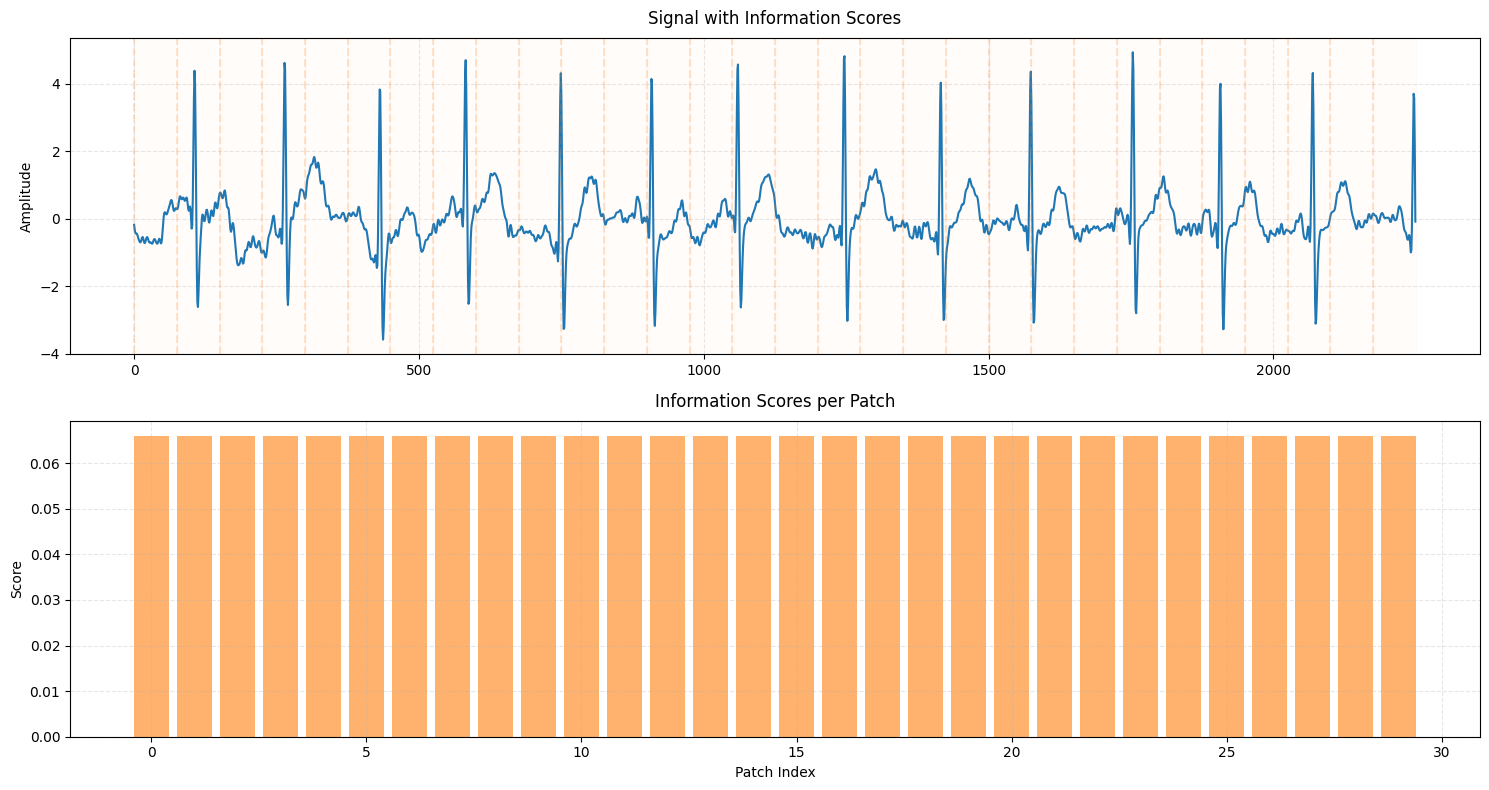

In [79]:
def plot_signal_with_mask_probs(signal, mask_probs, patch_size=30):
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    fig.patch.set_facecolor('white')  # 设置白色背景
    
    # 绘制原始信号
    ax1.plot(range(len(signal)), signal, color='#1f77b4', linewidth=1.5, label='Signal')
    ax1.set_title('Signal with Information Scores', fontsize=12, pad=10)
    ax1.set_ylabel('Amplitude', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # 添加patch分割和概率值
    for i in range(len(mask_probs)):
        # patch边界
        x_pos = i * patch_size
        ax1.axvline(x=x_pos, color='#ff7f0e', linestyle='--', alpha=0.2)
        
        # 半透明颜色块
        ax1.axvspan(i*patch_size, (i+1)*patch_size, 
                   alpha=float(mask_probs[i])*0.3,  # 降低透明度
                   color='#ff7f0e',
                   label=f'Patch {i}' if i == 0 else "")
        
        # 概率值标注
        patch_center = i * patch_size + patch_size/2
        score = float(mask_probs[i])
        if score > 0.2:  # 只显示重要性较高的分数
            ax1.text(patch_center, ax1.get_ylim()[1], 
                    f'{score:.2f}', 
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    rotation=90,
                    fontsize=8,
                    color='#2f4f4f')
    
    # 绘制概率条形图
    patch_positions = np.arange(len(mask_probs))
    bars = ax2.bar(patch_positions, mask_probs.cpu().detach().numpy(), 
                  alpha=0.6, color='#ff7f0e', width=0.8)
    
    # 在柱状图上添加数值标签
    for bar in bars:
        height = bar.get_height()
        if height > 0.5:  # 只显示重要性较高的分数
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=8)
    
    ax2.set_title('Information Scores per Patch', fontsize=12, pad=10)
    ax2.set_xlabel('Patch Index', fontsize=10)
    ax2.set_ylabel('Score', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.3)
    
    # 调整布局
    plt.tight_layout()
    plt.show()

# 使用示例：
sample_idx = 0  # 选择第一个样本
signal = x[sample_idx, 0].cpu().numpy()  # [1200]
probs = normalized_tensor[sample_idx].detach()  # [40]
plot_signal_with_mask_probs(signal, probs, patch_size=75)

<Figure size 640x480 with 0 Axes>

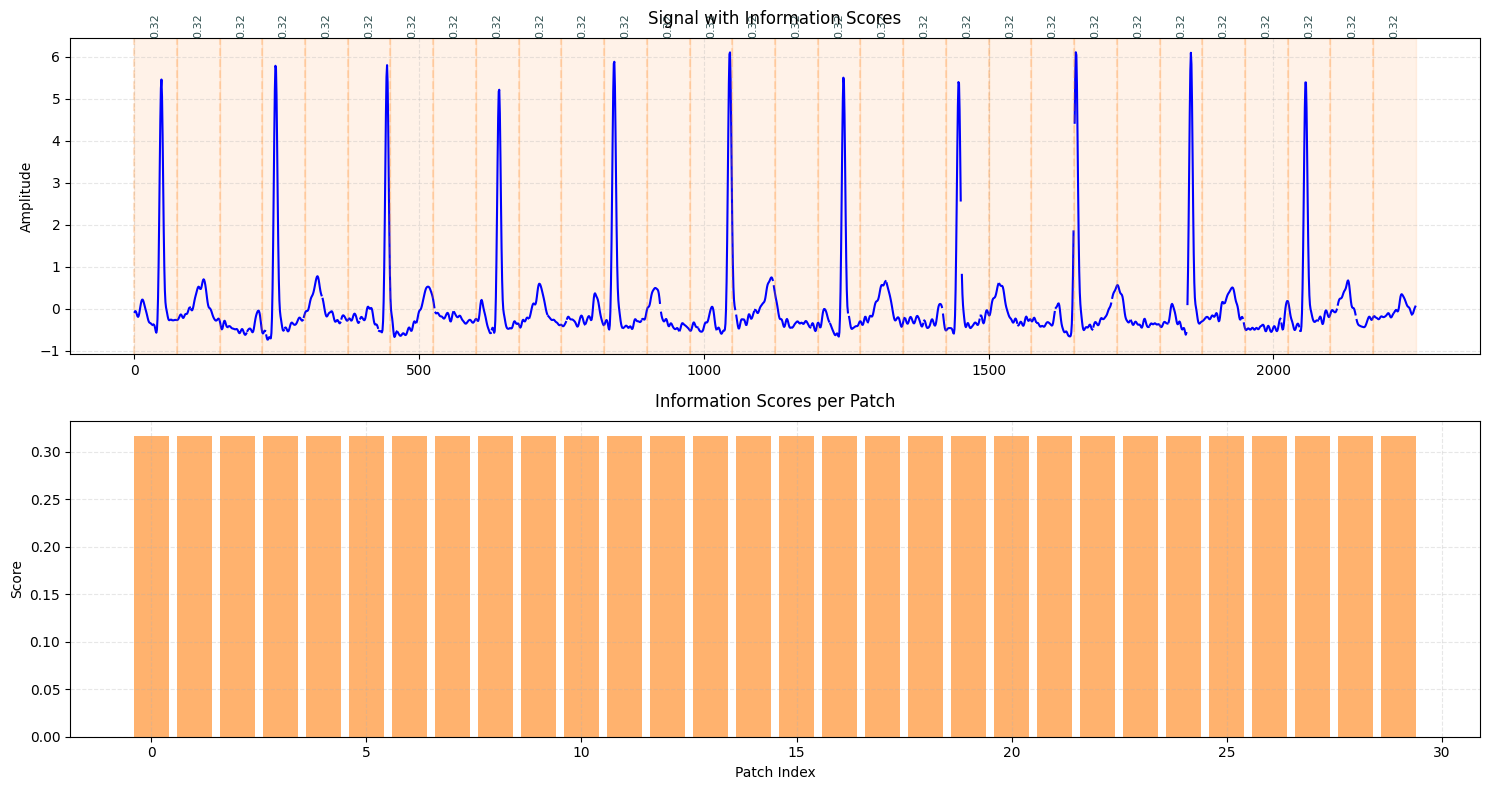

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_signal_with_mask_probs(signal, mask_probs, period_mask, patch_size=30):
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    fig.patch.set_facecolor('white')  # 设置白色背景

    # 绘制原始信号，按照 period_mask 区分颜色
    true_color = '#1f77b4'  # 对应 True 的颜色
    false_color = '#ff0000'  # 对应 False 的颜色

    # for i in range(len(signal)):
    #     color = true_color if period_mask[i] else false_color
    #     ax1.plot([i, i+1], signal[i:i+2], color=color, linewidth=1.5)
    
     # 分段绘制信号，按mask分别绘制红色和蓝色的部分
    start_idx = 0
    for i in range(1, len(signal)):
        if period_mask[i] != period_mask[start_idx]:  # 检查信号段是否改变
            ax1.plot(range(start_idx, i), signal[start_idx:i], 
                     color='r' if period_mask[start_idx] else 'b', linewidth=1.5)
            start_idx = i  # 更新起始位置

    # 绘制最后一段
    ax1.plot(range(start_idx, len(signal)), signal[start_idx:], 
             color='r' if period_mask[start_idx] else 'b', linewidth=1.5)
    ax1.set_title('Signal with Information Scores', fontsize=12, pad=10)
    ax1.set_ylabel('Amplitude', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.3)
    

    # 添加 patch 分割和概率值
    for i in range(len(mask_probs)):
        # patch 边界
        x_pos = i * patch_size
        ax1.axvline(x=x_pos, color='#ff7f0e', linestyle='--', alpha=0.2)

        # 半透明颜色块
        ax1.axvspan(i * patch_size, (i + 1) * patch_size, 
                    alpha=float(mask_probs[i]) * 0.3,  # 降低透明度
                    color='#ff7f0e',
                    label=f'Patch {i}' if i == 0 else "")

        # 概率值标注
        patch_center = i * patch_size + patch_size / 2
        score = float(mask_probs[i])
        if score > 0.2:  # 只显示重要性较高的分数
            ax1.text(patch_center, ax1.get_ylim()[1], 
                     f'{score:.2f}', 
                     horizontalalignment='center',
                     verticalalignment='bottom',
                     rotation=90,
                     fontsize=8,
                     color='#2f4f4f')

    # 绘制概率条形图
    patch_positions = np.arange(len(mask_probs))
    bars = ax2.bar(patch_positions, mask_probs.cpu().detach().numpy(), 
                   alpha=0.6, color='#ff7f0e', width=0.8)

    # 在柱状图上添加数值标签
    for bar in bars:
        height = bar.get_height()
        if height > 0.5:  # 只显示重要性较高的分数
            ax2.text(bar.get_x() + bar.get_width() / 2., height,
                     f'{height:.2f}',
                     ha='center', va='bottom', fontsize=8)

    ax2.set_title('Information Scores per Patch', fontsize=12, pad=10)
    ax2.set_xlabel('Patch Index', fontsize=10)
    ax2.set_ylabel('Score', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.3)

    # 调整布局
    plt.tight_layout()
    plt.show()

# 使用示例：
sample_idx = 19  # 选择样本索引
signal = x[sample_idx, 0].cpu().numpy()  # [1200]
probs = normalized_tensor[sample_idx].detach()  # [40]
period_mask_value =period_mask[sample_idx,0,0].cpu().numpy()   # 随机生成布尔 mask
plot_signal_with_mask_probs(signal, probs, period_mask_value, patch_size=75)

In [9]:
class TimeSeriesWeighting(nn.Module):
    def __init__(self, len, patch_size=30, num_patches=40):
        super(TimeSeriesWeighting, self).__init__()
        # 初始化权重为可训练参数
        import torch.distributions as dist
        normal_dist = dist.Normal(0, 1)
        weight_value = normal_dist.sample()
        self.weights = nn.Parameter(torch.sigmoid(weight_value))

    def forward(self, x):
        B, N, L = x.shape
        patch_size = 75
        num_patches = L // patch_size

        # 计算 FFT 和频率
        x_np = x.detach().cpu().numpy()
        X_fft = np.fft.fft(x_np, axis=2)
        freqs = np.fft.fftfreq(L)

        # 计算频域能量并找到主频率
        X_fft_energy = np.abs(X_fft) ** 2
        main_freqs = freqs[np.argsort(X_fft_energy, axis=2)[:, :, -6:]]  # Top-6频率

        # 计算理想峰值间隔
        main_periods = np.abs(1 / main_freqs)
        main_periods[np.isinf(main_periods)] = 0  # 处理除以零的情况
        print("main_periods.shape:",main_periods.shape)
        print("main_periods:",main_periods[0])

        # 初始化加权结果
        weighted_x = torch.zeros(B, num_patches, device=x.device)

        # 矢量化计算每个片段的加权
        for b in range(B):
            for n in range(N):
                for i in range(0, 6, 2):  # 每隔两个主频
                    if main_periods[b, n, i] == 0:
                        continue
                    ideal_peak_interval = int(main_periods[b, n, i])
                    peaks = np.arange(0, L, ideal_peak_interval)
                    
                    # 计算加权
                    patch_indices = np.floor(peaks / patch_size).astype(int)
                    patch_indices = patch_indices[patch_indices < num_patches]  # 剔除越界索引
                    weighted_x[b, patch_indices] += self.weights

        return weighted_x

In [ ]:
import torch
import numpy as np

# 设置随机种子以确保结果可重现
torch.manual_seed(42)
np.random.seed(42)

# # 参数配置
# B = 4  # 批次大小
# N = 3  # 每个样本的通道数
# L = 2250  # 每个通道的时间序列长度
# patch_size = 75  # 每个补丁的大小

# # 生成一个随机的时间序列数据 (B, N, L)
# x = torch.randn(B, N, L)

# 打印输入数据的形状
print("输入数据的形状: ", x.shape)

# 可选：保存数据到文件，以便后续加载
torch.save(x, "test_data.pt")

# 使用 TimeSeriesWeighting 类进行加权操作
model = TimeSeriesWeighting(len)

# 测试模型
weighted_x = model(x)

# 打印加权后的结果形状
print("加权后的结果形状: ", weighted_x.shape)
# 计算最小值和最大值
min_val = weighted_x.min()
max_val = weighted_x.max()

# 归一化到 [0, 1]
normalized_tensor = (weighted_x - min_val) / (max_val - min_val)

print("归一化后的张量:",normalized_tensor)
weighted_x
